In [2]:
import pandas as pd

In [3]:
import pandas as pd

import numpy as np
from numpy import exp, log

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.ioff()
sns.set()

from functools import partial

In [4]:
df = pd.read_excel('CCRB_database_raw.xlsx')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323911 entries, 0 to 323910
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   AsOfDate           323911 non-null  datetime64[ns]
 1   Unique Id          323911 non-null  int64         
 2   First Name         323906 non-null  object        
 3   Last Name          323911 non-null  object        
 4   Rank               323911 non-null  object        
 5   Command            323911 non-null  object        
 6   ShieldNo           323855 non-null  float64       
 7   Complaint Id       290649 non-null  float64       
 8   Incident Date      270418 non-null  datetime64[ns]
 9   FADO Type          290649 non-null  object        
 10  Allegation         290228 non-null  object        
 11  Board Disposition  290649 non-null  object        
 12  NYPDDisposition    11464 non-null   object        
 13  PenaltyDesc        9992 non-null    object  

In [6]:
df.describe()

,Unique Id,ShieldNo,Complaint Id
count,323911.000000,323855.000000,2.906490e+05
mean,39220.746721,8393.289228,1.263439e+08
std,22824.135790,9262.194906,9.356904e+07
min,1.000000,0.000000,6.278008e+06
25%,19168.000000,1620.000000,9.404761e+06
50%,39457.000000,4667.000000,2.004009e+08
75%,56169.000000,13053.000000,2.011027e+08
max,81550.000000,93187.000000,2.020037e+08


In [7]:
df.head()

,AsOfDate,Unique Id,First Name,Last Name,Rank,Command,ShieldNo,Complaint Id,Incident Date,FADO Type,Allegation,Board Disposition,NYPDDisposition,PenaltyDesc
0,2020-07-14,43921,Richard,Aalbue,POM,H BKLYN,3619.0,6290465.0,NaT,Force,Force,Unsubstantiated,NaN,NaN
1,2020-07-14,52580,Walter,Aanonsen,LT,MOUNTED,0.0,8300607.0,NaT,Force,Force,Complainant Unavailable,NaN,NaN
2,2020-07-14,52580,Walter,Aanonsen,LT,MOUNTED,0.0,8800504.0,1988-02-15,Force,Beat,Unsubstantiated,NaN,NaN
3,2020-07-14,52580,Walter,Aanonsen,LT,MOUNTED,0.0,9201176.0,1992-04-02,Abuse of Authority,Vehicle Searched,Unsubstantiated,NaN,NaN
4,2020-07-14,52580,Walter,Aanonsen,LT,MOUNTED,0.0,9201176.0,1992-04-02,Discourtesy,Nasty Words,Unsubstantiated,NaN,NaN


In [8]:
len(df)

323911

# 0. Formatting

In [9]:
df.rename(lambda col : col.lower().replace(' ', '_'), axis = 'columns', inplace = True)

In [10]:
counts = df.groupby('unique_id').apply(lambda df : len(df.complaint_id.unique()))

## Graph

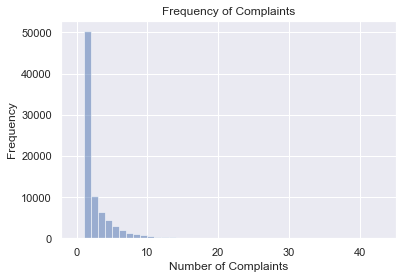

In [11]:
x_max = max(counts) + 1 + 2
bins = range(x_max)
fig, ax = plt.subplots()
sns.distplot(counts, norm_hist = False, kde = False, bins = bins, ax = ax, hist_kws = {'alpha' : 0.5, 'label' : 'Data'})
ax.set_xlabel('Number of Complaints')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Complaints')

plt.show()

# 1. Zero-Truncated Poisson and Pareto

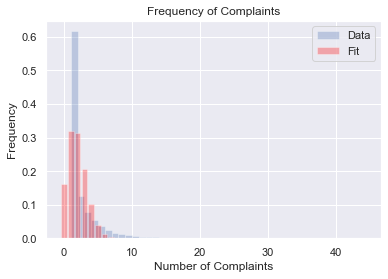

Log Likelihood: -2.003


In [12]:
from models.zero_truncated_poisson import ZeroTruncatedPoisson

model = ZeroTruncatedPoisson()
model.fit(counts)

from graphing import graph_dists

x_max = max(counts) + 3
xs, ys = model.plot(max_count = x_max, include_zero = True, normalize = True)

fig, ax = graph_dists(counts, x_max, xs, ys)
# It's pretty apparent that the model does not fit the data

plt.show()
print(f'Log Likelihood: {model.log_likelihood():.3f}')

# Compute the Distributions to get the KL-Div

from scipy.special import rel_entr as kl_div

pdfs = counts.value_counts(normalize = True).reset_index().rename({
  'index'         : 'k',
  'unique_mos_id' : 'empirical',
}, axis = 'columns').sort_values('k')

pdfs['zt_poisson'] = pdfs.k.map(model.pmf)

In [ ]:
from scipy.stats import pareto

b, loc, scale = pareto.fit(counts, floc = 0)
model = pareto(b, loc, scale)
b

x_max = max(counts) + 1 + 2

xs = np.arange(1, x_max)
ys = model.pdf(xs)

fig, ax = graph_dists(counts, x_max, xs, ys)

plt.show()

def logpmf(model, k):
  return log(model.cdf(k+1) - model.cdf(k))

pareto_logpmf = partial(logpmf, model)
log_likelihood = counts.map(pareto_logpmf).mean()

print(f'Log Likelihood: {log_likelihood:.3f}')

pdfs['pareto'] = pdfs.k.map(lambda k : exp(pareto_logpmf(k)))

/Users/rcharan/anaconda3/envs/synovium/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


# 2. Negative Binomial

In [52]:
from scipy.stats import nbinom
from statsmodels.base.model import GenericLikelihoodModel
from scipy.optimize import minimize

In [53]:
def log_likelihood_nbinom(counts, r, p, loc):
  model = nbinom(r, p, loc = loc)
  log_likelihood = model.logpmf(counts)
  return -log_likelihood.sum()

In [54]:
log_likelihood = lambda params : log_likelihood_nbinom(counts, *params, 1)

In [55]:
counts.describe()

count    81550.000000
mean         2.287652
std          2.544950
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         41.000000
dtype: float64

In [56]:
# guess with method of moments. But this doesn't work
e_x = counts.mean()
v_x = counts.var()

r = e_x ** 2 / (v_x - e_x)
p = 1 - e_x / v_x
print(r, p)

1.2492720247196636 0.6467913630004483


In [62]:
guess = np.array([0.3, 0.2])
result = minimize(log_likelihood, guess, method = 'Nelder-Mead')

result

 final_simplex: (array([[0.28874276, 0.18316445],
       [0.28871538, 0.18315944],
       [0.28870858, 0.1831373 ]]), array([118178.06390264, 118178.06393071, 118178.0639874 ]))
           fun: 118178.06390263616
       message: 'Optimization terminated successfully.'
          nfev: 50
           nit: 26
        status: 0
       success: True
             x: array([0.28874276, 0.18316445])

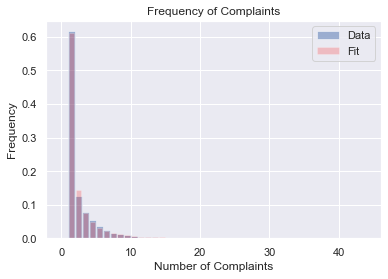

Log Likelihood: -1.449


In [63]:
r, p = result.x
model = nbinom(r, p, loc = 1)
x_max = max(counts) + 1 + 2
bins = range(x_max)
fig, ax = plt.subplots()
sns.distplot(counts, norm_hist = True, kde = False, bins = bins, ax = ax, hist_kws = {'alpha' : 0.5, 'label' : 'Data'})
ax.set_xlabel('Number of Complaints')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Complaints')

xs = np.arange(1, x_max)
ys = model.pmf(xs)

ax.bar(xs + 0.5, ys, color = 'red', alpha = 0.2, label = 'Fit')
ax.legend();

plt.show()

log_likelihood = counts.map(model.logpmf).mean()
print(f'Log Likelihood: {log_likelihood:.3f}')

# 2. Empirical PDF Log Likelihood

In [43]:
log_likelihood = counts.reset_index().merge(
  counts.value_counts(normalize = True).rename('pmf'),
  left_on = 'unique_id',
  right_index = True,
  validate = 'm:1'
)
log_pmf = log(log_likelihood.pmf)

log_pmf.mean()

-7.210147950700328

# 3. KL–Div

In [71]:
from scipy.special import rel_entr as kl_div

In [69]:
pdfs = counts.value_counts(normalize = True).reset_index().rename({
  'index'         : 'k',
  0               : 'empirical',
}, axis = 'columns').sort_values('k')
pdfs['negative_binomial'] = pdfs.k.map(model.pmf)

In [72]:
model_names = ['negative_binomial']
divs = map(lambda col : 
     kl_div(pdfs.empirical, pdfs[col]).sum(),
  model_names
)

kl_divs = dict(zip(model_names, divs))

In [73]:
kl_divs

{'negative_binomial': 0.0024666675737633655}